<a href="https://colab.research.google.com/gist/aanorbel/957576569ee9a2da72bd534af3d45fdf/unet-archt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Architecture

https://github.com/bnsreenu/python_for_microscopists/blob/master/231_234_BraTa2020_Unet_segmentation/simple_3d_unet.py




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


# Load and Preprocess CIFAR-10 Data

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Resize to a smaller subset for speed during development
#x_train, _, = train_test_split(x_train, test_size=0.9, random_state=42)
#x_test, _, = train_test_split(x_test, test_size=0.9, random_state=42)

print(f"Training samples: {x_train.shape}, Testing samples: {x_test.shape}")


Training samples: (50000, 32, 32, 3), Testing samples: (10000, 32, 32, 3)


# Visualize Sample Images

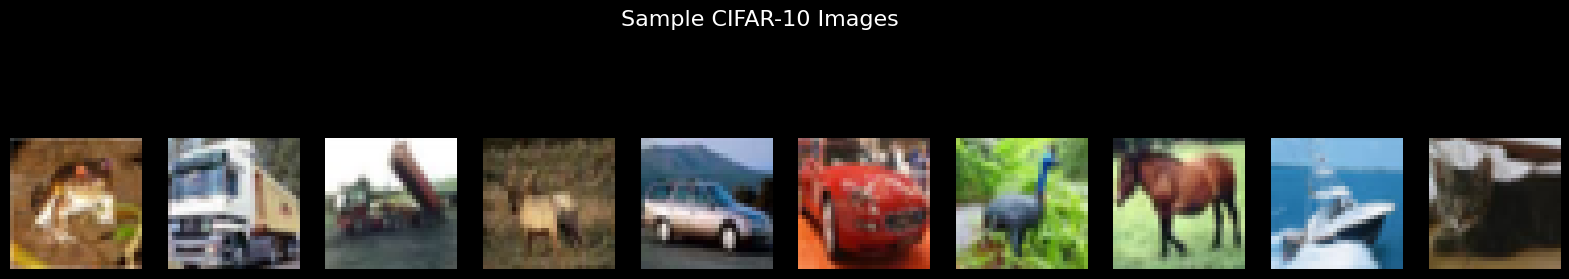

In [3]:
def show_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.suptitle("Sample CIFAR-10 Images", fontsize=16)
    plt.show()

show_images(x_train)


# Define U-Net Architecture (Autoencoder Version for RGB Images)

## Understanding the U-Net Architecture

The U-Net, proposed by Ronneberger et al. in 2015, is an encoder-decoder style deep convolutional network. Its U-shape is a result of connecting the downsampling path (encoder) with the upsampling path (decoder) via "skip connections".

### Encoder (Downsampling Path)

The encoder part (left side of the 'U') is a standard convolutional network that captures context. It consists of:

- Repeated application of two 3x3 convolutions, each followed by a Rectified Linear Unit (ReLU) activation function and Batch Normalization.
- A 2x2 max pooling operation with stride 2 for downsampling. This halves the spatial dimensions (height and width) and typically doubles the number of feature channels.

As the network goes deeper, it learns more abstract and semantic features, but spatial information is reduced.

### Bottleneck

This is the deepest part of the network, connecting the encoder and decoder. It typically consists of a couple of convolutional blocks without any pooling layers. It represents the most compressed feature representation.

### Decoder (Upsampling Path)

The decoder part (right side of the 'U') aims for precise localization using upsampling. It consists of:

- An upsampling layer (often `Conv2DTranspose` or `UpSampling2D`) that doubles the spatial dimensions and halves the number of feature channels.
- A crucial **concatenation** with the corresponding feature map from the encoder path (the **skip connection**).
- Followed by two 3x3 convolutions, each with ReLU activation and Batch Normalization.

In [4]:
def build_unet(input_shape=(32, 32, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    bn = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(bn)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model


# Compile the Model

In [5]:
unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
unet_model.summary()


2025-06-17 02:20:07.152452: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-06-17 02:20:07.152482: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-17 02:20:07.152496: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-17 02:20:07.152514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-17 02:20:07.152528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 471,619 (1.80 MB)

 Trainable params: 471,619 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [ ]:
history = unet_model.fit(
    x_train, x_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_test, x_test)
)


Epoch 1/20


2025-06-17 02:20:09.793235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 184s 231ms/step - loss: 0.0085 - mae: 0.0545 - val_loss: 3.2951e-04 - val_mae: 0.0130
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 175s 223ms/step - loss: 3.2745e-04 - mae: 0.0131 - val_loss: 1.6936e-04 - val_mae: 0.0089
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 169s 217ms/step - loss: 2.1168e-04 - mae: 0.0106 - val_loss: 1.8013e-04 - val_mae: 0.0105
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 167s 213ms/step - loss: 1.6988e-04 - mae: 0.0094 - val_loss: 9.7868e-05 - val_mae: 0.0069
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 167s 214ms/step - loss: 1.3956e-04 - mae: 0.0085 - val_loss: 7.9308e-05 - val_mae: 0.0062
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 166s 212ms/step - loss: 1.1816e-04 - mae: 0.0079 - val_loss: 1.0263e-04 - val_mae: 0.0080
Epoch 7/20
245/782 ━━━━━━━━━━━━━━━━━━━━ 1:52 210ms/step - loss: 9.0782e-05 - mae: 0.0070

# Visualize Training History

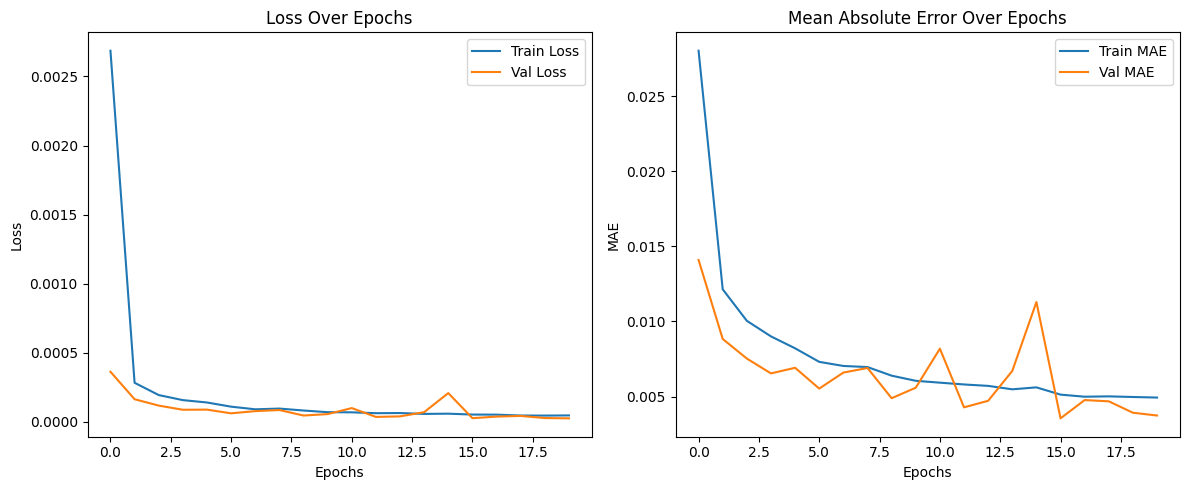

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['mae'], label='Train MAE')
    plt.plot(hist.history['val_mae'], label='Val MAE')
    plt.title('Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


# Show Reconstructions vs Original

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


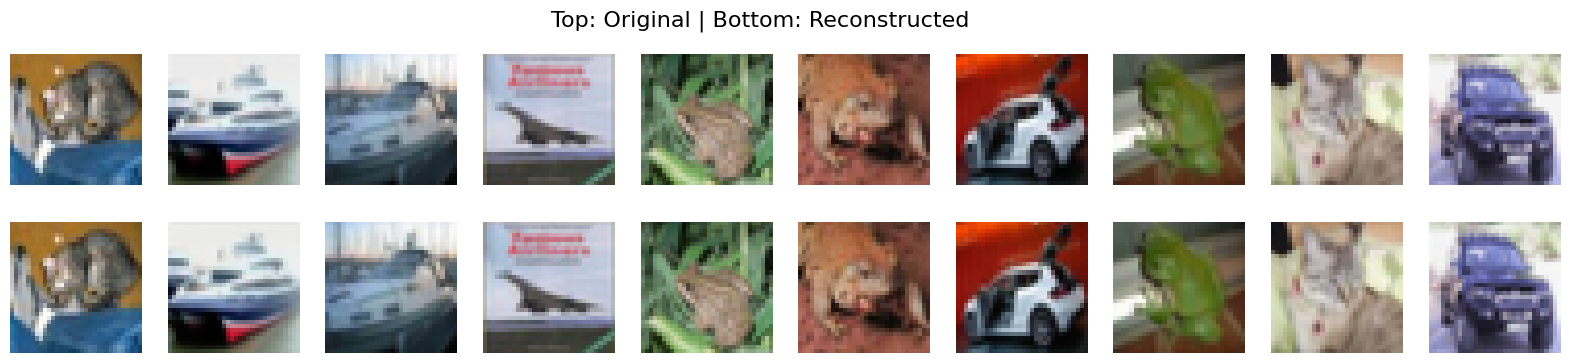

In [ ]:
def display_reconstructions(model, x_data):
    preds = model.predict(x_data[:10])
    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(x_data[i])
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(preds[i])
        plt.axis("off")
    plt.suptitle("Top: Original | Bottom: Reconstructed", fontsize=16)
    plt.show()

display_reconstructions(unet_model, x_test)
